**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Building dataset](#toc1_2_)    
  - [Model training](#toc1_3_)    
  - [Lora implementation](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ds-complex-eos-tcra-tcrb-peptide-linker/ds_complex_eos_tcrA_tcrB_peptide_linker_nobind_test.csv
/kaggle/input/ds-complex-eos-tcra-tcrb-peptide-linker/ds_complex_eos_tcrA_tcrB_peptide_linker_bind_train.csv
/kaggle/input/ds-complex-eos-tcra-tcrb-peptide-linker/ds_complex_eos_tcrA_tcrB_peptide_linker_nobind_train.csv
/kaggle/input/ds-complex-eos-tcra-tcrb-peptide-linker/ds_complex_eos_tcrA_tcrB_peptide_linker_bind_test.csv
/kaggle/input/d/yasininal/plusnegssinglecolumn/indep_plusnegs_plm_only_TRB.csv
/kaggle/input/d/yasininal/plusnegssinglecolumn/traintest_plusnegs_plm_only_antigen.csv
/kaggle/input/d/yasininal/plusnegssinglecolumn/indep_plusnegs_plm_only_antigen.csv
/kaggle/input/d/yasininal/plusnegssinglecolumn/traintest_plusnegs_plm_only_TRB.csv
/kaggle/input/d/yasininal/plusnegssinglecolumn/indep_plusnegs_plm_only_TRA.csv
/kaggle/input/d/yasininal/plusnegssinglecolumn/traintest_plusnegs_plm_only_TRA.csv


## <a id='toc1_1_'></a>[Imports](#toc0_)

In [5]:
!pip install focal_loss_torch
!pip install peft==0.4.0

import torch
from transformers import AutoTokenizer, EsmForSequenceClassification
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from accelerate import Accelerator
from focal_loss.focal_loss import FocalLoss
from torch.optim import AdamW
from transformers import get_scheduler
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

sns.set_theme()
sns.set_context('paper')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 3.4 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
cuda = torch.cuda.is_available()

In [7]:
from pathlib import Path

## <a id='toc1_2_'></a>[Building dataset](#toc0_)

First, we need to construct our data set. Since we are training a binary sequence classifier, we need positive and negative examples. 

We simply split our data into a train/test split and place the positive and negative example sequences into separate text files.

In [8]:
sequence_field = 3
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df
            
        plt.hist([len(s[0]) for s in self.data], bins=64)
        plt.show()
            
        print(f"Initialized dataset consisting of {self.data.shape[0]} sequences.")
            
    def __getitem__(self, idx):
        return self.data.iloc[idx].tolist()
    
    def __len__(self):
        return self.data.shape[0]

In [9]:
data = 'plusnegs_antigen'

In [10]:
if data == 'ds_complex':
    data_path = Path('/kaggle/input/ds-complex-eos-tcra-tcrb-peptide-linker')
if data == 'plusnegs_antigen':
    train_path = Path('/kaggle/input/d/yasininal/plusnegssinglecolumn/traintest_plusnegs_plm_only_antigen.csv')
    test_path = Path('/kaggle/input/d/yasininal/plusnegssinglecolumn/indep_plusnegs_plm_only_antigen.csv')
if data == 'plusnegs_TRA':
    train_path = Path('/kaggle/input/d/yasininal/plusnegssinglecolumn/traintest_plusnegs_plm_only_TRA.csv')
    test_path = Path('/kaggle/input/plusnegssinglecolumn/indep_plusnegs_plm_only_TRA.csv')
if data == 'plusnegs_TRB':
    train_path = Path('/kaggle/input/d/yasininal/plusnegssinglecolumn/traintest_plusnegs_plm_only_TRB.csv')
    test_path = Path('/kaggle/input/d/yasininal/plusnegssinglecolumn/indep_plusnegs_plm_only_TRB.csv')


In [11]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

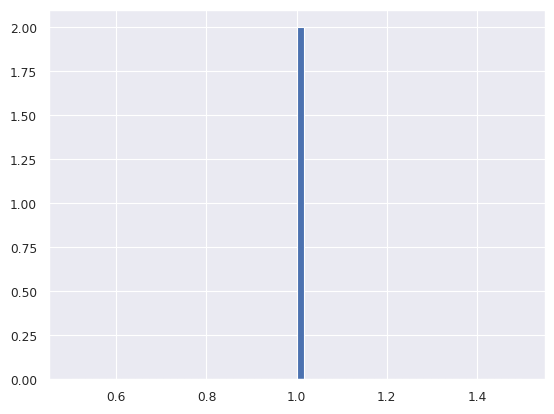

Initialized dataset consisting of 38536 sequences.


In [12]:
train = SequenceDataset(df_train)

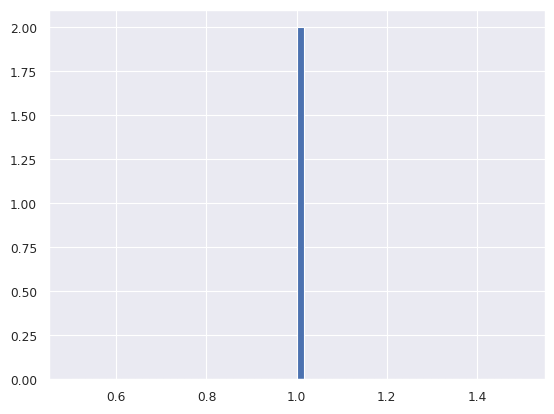

Initialized dataset consisting of 2016 sequences.


In [13]:
test = SequenceDataset(df_test)

## Data Loader

In [14]:
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False)

## <a id='toc1_3_'></a>[Model training](#toc0_)

We are using the [ESM-2 model](https://huggingface.co/docs/transformers/model_doc/esm) by Meta.


In [15]:
model_name = "facebook/esm2_t6_8M_UR50D"
#model_name = "facebook/esm2_t12_35M_UR50D"
#model_name = "facebook/esm2_t30_150M_UR50D"

# Initialize pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForSequenceClassification.from_pretrained(model_name)
if cuda:
    model = model.cuda()

# Feel free to play around with these hyper-parameters
lr = 5e-5
num_epochs = 3

# This is somewhat important, as sequences that are longer than this just get truncated to this length. 
# For very long sequences, this can render the model useless. In our experience, this generally still works fine. Notice that memory requirements grow dramatically with max_length!
#max_length = 1028
max_length = 630

optimizer = AdamW(model.parameters(), lr=lr)

# A linear lr schedule worked well in our experiments. 
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
     name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))  

# Replacing the standard cross-entropy loss by a focal loss improved our results slightly.
focal = FocalLoss(gamma=0.7)

if cuda:
    accelerator = Accelerator(mixed_precision="fp16") # Change to be able to run in old kaggle gpus
else:
    accelerator = Accelerator(mixed_precision="bf16")
    
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You

  0%|          | 0/28902 [00:00<?, ?it/s]

Given a trained model, we'd like to evaluate how well we are doing.

Make a prediction for every example in the test set and report total accuracy (only makes sense if our test set is balanced!) and a calibration curve.

In [16]:
def validate(model):
    model.eval()
    
    targets = []
    probabilities = []
    predictions = []
    
    for s, l in tqdm(test_loader):
        
        inputs = tokenizer(s, return_tensors='pt', padding="max_length", truncation=True,
                           max_length=max_length)
        if cuda:
            inputs = inputs.to("cuda")
        
        with torch.no_grad():
            logits = model(**inputs, labels=l).logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
        predictions.append(preds)    
        probabilities.append(probs)
        targets.append(l)
            
    targets = torch.cat(targets).cpu()
    probabilities = torch.cat(probabilities).cpu()
    predictions = torch.cat(predictions).cpu()
            
    # Visualize calibration curve
    # prob_true, prob_pred = calibration_curve(targets, probabilities[:,1], pos_label=None, n_bins=10, strategy='uniform')
    # sns.lineplot(x=prob_true, y=prob_pred)
    # sns.lineplot(x=np.linspace(0,1,5), y=np.linspace(0,1,5))
    # plt.show()
    
    print("Test accuracy:", accuracy_score(targets, predictions))
    print("Test precision:", precision_score(targets, predictions))
    print("Test recall:", recall_score(targets, predictions))
    print('Confusion matrix:\n', confusion_matrix(targets, predictions))
    
    # Reset our model to trraining mode before exiting evaluation, 
    # so we don't forget to do this later!
    model.train()
    
    return(targets, probabilities, predictions)


Now, we simply train our model and see how it performs.

In [ ]:
for epoch in range(num_epochs):
    model.train()
    
    for idx, (s, l) in enumerate(train_loader):
        
        inputs = tokenizer(s, return_tensors='pt', padding="max_length", truncation=True, 
                           max_length=max_length)
        if cuda:
            inputs = inputs.to("cuda")
        logits = model(**inputs, labels=l).logits
        
        if cuda:
            loss = focal(torch.softmax(logits, dim=1), l.cuda())
        else:
            loss = focal(torch.softmax(logits, dim=1), l)
        
        accelerator.backward(loss)
        lr_scheduler.step()
        optimizer.step()
        optimizer.zero_grad()
        
        progress_bar.update(1)
          
    validate(model)

  0%|          | 0/504 [00:00<?, ?it/s]

Test accuracy: 0.07142857142857142
Test precision: 0.07142857142857142
Test recall: 1.0
Confusion matrix:
 [[   0 1872]
 [   0  144]]


In [ ]:
model.save_pretrained('./lora_tra_trb_training_peptide_all_dataset_eos')

## <a id='toc1_4_'></a>[Lora implementation](#toc0_)

For larger models, you might have to do parameter efficient fine-tuning. Here, we quickly demonstrate this using a technique called [LoRA](https://arxiv.org/abs/2106.09685).

In [ ]:
model_name = "facebook/esm2_t12_35M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForSequenceClassification.from_pretrained(model_name).cuda()

#
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, 
    lora_dropout=0.1, bias="none", target_modules=["query", "value"], 
    modules_to_save=["decode_head"], # make sure to set classification heads here to save so we do train them
)

lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

optimizer = AdamW(lora_model.parameters(), lr=lr)
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
     name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

In [ ]:
for epoch in range(num_epochs):
    lora_model.train()
    
    for s, l in train_loader:
        
        inputs = tokenizer(s, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to("cuda")
        logits = lora_model(**inputs, labels=l).logits
        
        loss = focal(torch.softmax(logits, dim=1), l.cuda())
        
        loss.backward()
        lr_scheduler.step()
        optimizer.step()
        optimizer.zero_grad()
        
        progress_bar.update(1)
        
    validate(lora_model)

Results with Lora and a larger model do not get better, but maybe increasing the number of epochs would do the trick. Actually, the test accuracy keeps improving.

## Results:
data: plusnegs with only antigen column

    result: test accuracy: 0.07
    test precision: 0.7
    Confusion matrix:
     [[   0 1872]
     [   0  144]]